# Ungraded Lab: Generating Text from Irish Lyrics

## Imports

In [1]:
import tensorflow as tf
import numpy as np 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-07-09 09:57:44.554241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 09:57:44.554357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 09:57:44.689662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Building the Word Vocabulary

In [2]:
!pip install gdown==5.1.0

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
# Download the dataset
!gdown --id 15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT
To: /kaggle/working/irish-lyrics-eof.txt
100%|██████████████████████████████████████| 69.0k/69.0k [00:00<00:00, 78.9MB/s]


In [4]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay', 'then came a lusty sailor', 'who chanced to pass my way', 'and stole my bunch of thyme away', 'the sailor gave to me a rose', 'a rose that never would decay', 'he gave it to me to keep me reminded', 'of when he stole my thyme away', 'sleep, my child, and peace attend thee', 'all through the night', 'guardian angels god will send thee', 'soft the drowsy hours are creeping', 'hill and dale in slumber sleeping', 'i my loving vigil keeping', 'while the moon her watch is keeping', 'while the weary world is sleeping', 'oer thy spirit gently stealing', 'visions of delight revealing', 'breathes a pure 

In [6]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'thro

## Preprocessing the Dataset

In [7]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [8]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence: 
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[51, 12, 96, 1217, 48, 2, 69]


In [9]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
decoded to text: ['come all ye maidens young and']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 69


In [10]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0    0   51   12   96 1217
   48]
decoded to text: ['come all ye maidens young']
one-hot label: [0. 0. 1. ... 0. 0. 0.]
index of label: 2


## Build and compile the Model

In [11]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [12]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0613 - loss: 6.8413
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1062 - loss: 5.8290
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1585 - loss: 5.0387
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2393 - loss: 4.0032
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3519 - loss: 3.1071
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4441 - loss: 2.5025
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5421 - loss: 1.9945
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6083 - loss: 1.6550
Epoch 9/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6572 - loss: 1.4338
Epoch 10/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6842 - loss: 1.2870
Epoch 11/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6873 - loss: 1.2920
Epoch 12/100
377/377 ━━━━━━━━━━━━━━━━━━━━

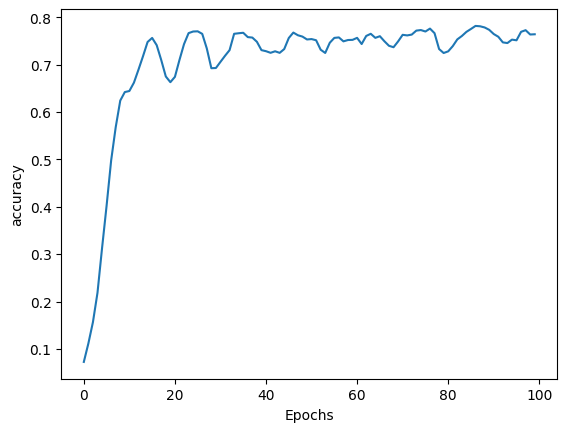

In [13]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

In [14]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:
		
		# Look up the word associated with the index. 
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope for a bowl out to the lattice above her head again hand on her lips lays her fingers and bells on her toes has in me heavenward upon erin go bragh shannon by spancil hill by aisey hill by aisey by lord cornwall spancil hill and moaning together of side by side by side by side gone by lord cornwall corporal casey saw where i was laid her thou art praise sing without corporal casey wear ill than by corporal casey nothing dear along around the sea may i reach heavens joys o bright heavens sun town again and gone


In [15]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])
	
  # Sort the probabilities in ascending order 
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		
		# Look up the word associated with the index. 
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope has play the mossy call all there i rose through may my sentence raw may sea may up in woe on so fondly at crystal with his death and find him to thine ale we wandered all bloom and die tbe stern were gone and poor fifty wished his color cant like some coffee i care not just a merry hand youll find white feet lay all its side gone by ballyjamesduff tree or regret or else will prove false me in a morning saw stream never forgets death will be he made it was the bed with me too
